In [1]:
import IPython.core.display
import matplotlib

def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1

apply_styles()

In [2]:
%%html
<style type="text/css">
@import url('https://fonts.googleapis.com/css?family=Playfair+Display');


div.text_cell_render {font-family: 'Playfair Display', serif; color: #13213b; line-height: 145%; font-size:16px;}
</style>

<span style="color:#13213b;">[Andrii Gakhov](https://www.gakhov.com) / PyCon UA 2018</span>
* * *
## An Introduction to Time Series Forecasting with Python
Time series is an important instrument to model, analyze and predict data collected over time. In this talk, we learn the basic theoretical concepts without going deep into mathematical aspects, study different models, and try them in practice using StatsModels, Prophet, scikit-learn, and keras.

# Part 3. Support Vector Machines
******

### OS visits to UK (All visits) 
The dataset represents the monthly total number of visits to the UK by overseas residents (in thousands)<br>from January 1980 to October 2017. 

#### Source: [Office for National Statistics](https://www.ons.gov.uk/peoplepopulationandcommunity/leisureandtourism/timeseries/gmaa/ott)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Seasonal SVR
----

### Load the data into Pandas DataFrame

In [5]:
import pandas as pd
df = pd.read_csv("data/GMAA-040218.csv", header=None, skiprows=6, parse_dates=[0], names=['period', 'value'])
df.value = df.value.astype(int)

In [6]:
import numpy as np
np.random.seed(seed=42)

train_range = df[df.period < '2010-01-01'].index
validate_range = df[(df.period >= '2010-01-01') & (df.period < '2014-01-01')].index
test_range = df[(df.period >= '2014-01-01') & (df.period < '2017-01-01')].index

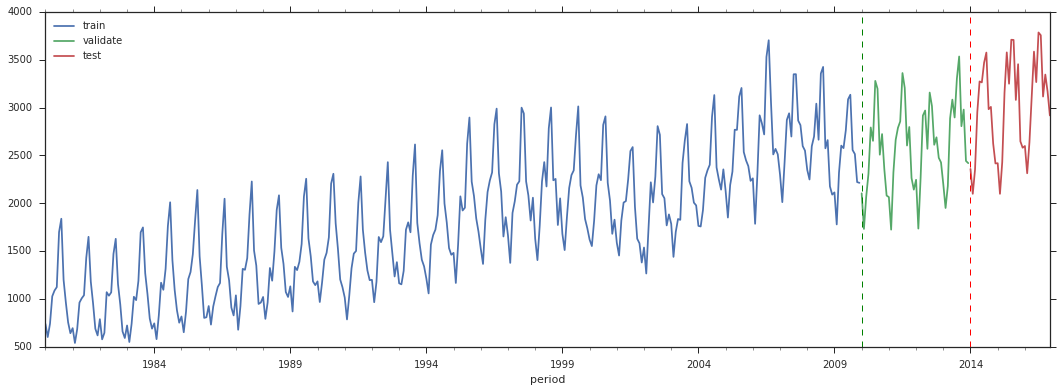

In [7]:
fig, ax = plt.subplots(figsize=(18,6))
df.loc[train_range].plot(x="period", y="value", ax=ax, label="train")
df.loc[validate_range].plot(x="period", y="value", ax=ax, label="validate")
df.loc[test_range].plot(x="period", y="value", ax=ax, label="test")

ax.axvline(pd.to_datetime(str(df.loc[validate_range].period.values[0])), c='green', ls='--', lw=1)
plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='red', ls='--', lw=1)
plt.legend(loc='upper left')

plt.savefig('images/svm-split.png');

### Prepare data for SVMR model

It's always a good idea to properly scale your data.

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df.value.astype(float).values.reshape(-1, 1));

### Convert observations into the seasonal learning data

Instead of directly leaning the number of visitors by the observation date only, we will learn those number using the past data in a season-long interval.

#### Thus, for new learning data $X(t)$ we take vectors with values from $[t - seasons, t)$, and the expected values $y=y(t)$ are simply the observations at the moment $t$.

In [9]:
def build_seasonal_learning_sequences(data, indices, seasons=12):
    train, validate, test = indices
    
    X_train = np.empty(shape=(0, seasons))
    y_train = np.array([])
    
    X_val = np.empty(shape=(0, seasons))
    y_val = np.array([])
    
    X_test = np.empty(shape=(0, seasons))
    y_test = np.array([])
    
    for i in range(seasons, data.shape[0]):
        X = data[i - seasons:i].reshape(1,-1)
        y = data[i].reshape(-1,)
        if i in train:
            X_train = np.concatenate((X_train, X), axis=0)
            y_train = np.append(y_train, y)
        elif i in validate:
            X_val = np.concatenate((X_val, X), axis=0)
            y_val = np.append(y_val, y)
        elif i in test:
            X_test = np.concatenate((X_test, X), axis=0)
            y_test = np.append(y_test, y)

    return X_train, y_train, X_val, y_val, X_test, y_test

#### For our data we observe the yearly seasonality, thus we select $seasons=12$

In [10]:
seasons = 12
indices = [train_range, validate_range, test_range]

X_train, y_train, X_val, y_val, X_test, y_test = build_seasonal_learning_sequences(
    data, indices, seasons)

## SVMR with scikit-learn

#### The main problem while working with SVMR is the choice of the kernel and good model's parameters.

#### The researches in this field recommend to use Radial Basis Function (RBF) and estimate other parameters experimentally.

In [11]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

C_range = np.logspace(-2, 10, 5)
gamma_range = np.logspace(-9, 3, 5)
param_grid = {
    "gamma": gamma_range,
    "C": C_range
}

cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=73)

grid = GridSearchCV(
    svm.SVR(kernel="rbf", max_iter=100),
    param_grid=param_grid,
    cv=cv)

#### Search for the best parameters and fit the model

In [12]:
grid.fit(X_train, y_train);

model = grid.best_estimator_
print("The best parameters are {} with a score of {:0.3f}".format(grid.best_params_, grid.best_score_))

The best parameters are {'C': 10000.0, 'gamma': 0.001} with a score of 0.929


### Evaluate the model

In [13]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def theils_u_metric(y_true, y_pred):
    """Calculate Theil's U statistics using observed and predicted vectors."""
    SS_res =  np.mean(np.square(y_true - y_pred))
    SS_true = np.mean(np.square(y_true))
    SS_pred = np.mean(np.square(y_pred))
    
    return np.sqrt(SS_res / (SS_true * SS_pred))

In [14]:
mae = 0
mse = 0
r2 = model.score(X_test, y_test)

print("MAE (val): {}".format(mae))
print("MSE (val): {}".format(mse))
print("R^2 (test): {:0.3f}".format(r2))

MAE (val): 0
MSE (val): 0
R^2 (test): 0.735


In [15]:
mae = 0
mse = 0
r2 = model.score(X_val, y_val)

print("MAE (val): {}".format(mae))
print("MSE (val): {}".format(mse))
print("R^2 (val): {:0.3f}".format(r2))

MAE (val): 0
MSE (val): 0
R^2 (val): 0.788


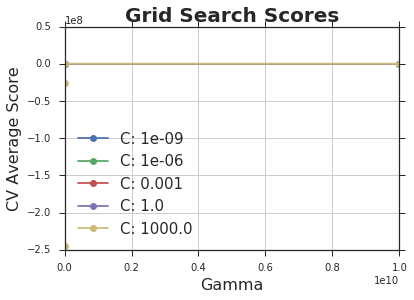

In [16]:
scores_mean = grid.cv_results_['mean_test_score']
scores_mean = np.array(scores_mean).reshape(len(gamma_range),len(C_range))

scores_sd = grid.cv_results_['std_test_score']
scores_sd = np.array(scores_sd).reshape(len(gamma_range),len(C_range))

_, ax = plt.subplots(1,1)

for idx, val in enumerate(gamma_range):
    ax.plot(C_range, scores_mean[idx,:], '-o', label= "C" + ': ' + str(val))

ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
ax.set_xlabel("Gamma", fontsize=16)
ax.set_ylabel('CV Average Score', fontsize=16)
ax.legend(loc="best", fontsize=15)
ax.grid('on')


plt.savefig('images/svm-grid-search.png');

### Forecast

In [17]:
yhat_train = model.predict(X_train)
yhat_val = model.predict(X_val)
yhat_test = model.predict(X_test)

yhat_train_unscaled = scaler.inverse_transform(yhat_train.reshape(-1,1)).flatten()
yhat_val_unscaled = scaler.inverse_transform(yhat_val.reshape(-1,1)).flatten()
yhat_test_unscaled = scaler.inverse_transform(yhat_test.reshape(-1,1)).flatten()

In [18]:
y_train_unscaled = scaler.inverse_transform(y_train.reshape(-1,1)).flatten()
y_val_unscaled = scaler.inverse_transform(y_val.reshape(-1,1)).flatten()
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

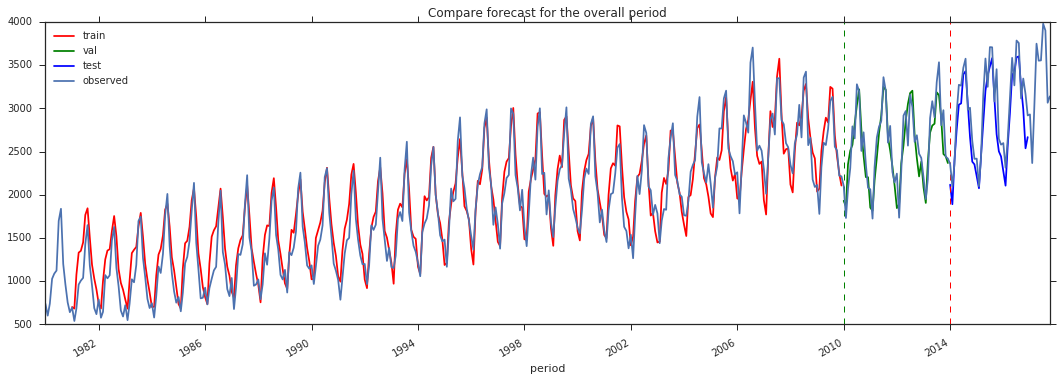

In [19]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[train_range].period.values)[seasons:], yhat_train_unscaled,
        color="red", label="train")
ax.plot(pd.to_datetime(df.loc[validate_range].period.values), yhat_val_unscaled,
        color="green", label="val")
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test_unscaled,
        color="blue", label="test")

ax.axvline(pd.to_datetime(str(df.loc[validate_range].period.values[0])), c='green', ls='--', lw=1)
plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='red', ls='--', lw=1)
df.plot(x="period", y="value", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Compare forecast for the overall period')

plt.savefig('images/svm-compare-forecast-overall.png')
plt.show();

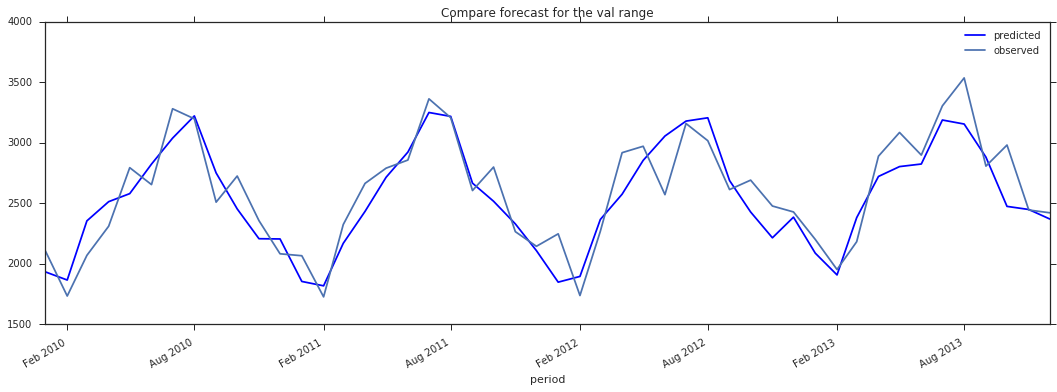

In [20]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[validate_range].period.values), yhat_val_unscaled,
        color="blue", label="predicted")

df.loc[validate_range].plot(x="period", y="value", ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the val range')

plt.savefig('images/svm-compare-forecast-valrange.png')
plt.show();

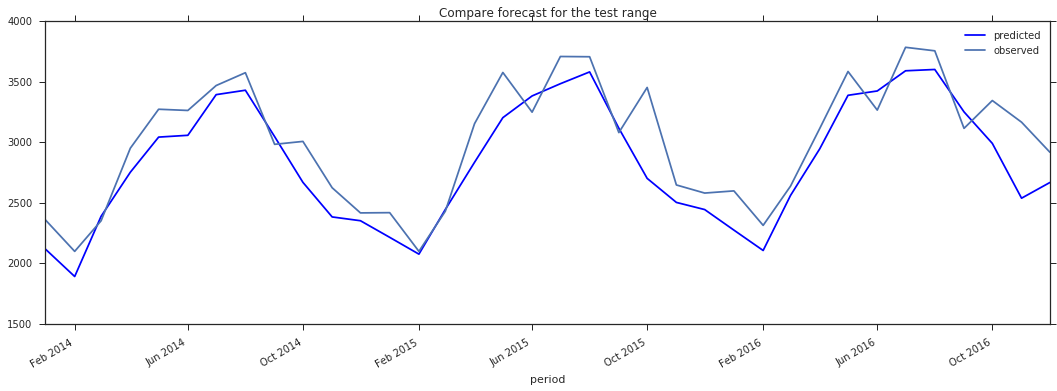

In [21]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test_unscaled,
        color="blue", label="predicted")

df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the test range')

plt.savefig('images/svm-compare-forecast-testrange.png')
plt.show();

### Evaluate the forecast

In [22]:
mae = mean_absolute_error(y_test_unscaled, yhat_test_unscaled)
mse = mean_squared_error(y_test_unscaled, yhat_test_unscaled)
r2 = r2_score(y_test_unscaled, yhat_test_unscaled)
u = theils_u_metric(y_test_unscaled, yhat_test_unscaled)

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("U   (test): {:0.6f}".format(u))

MAE (test): 205
MSE (test): 64670
R2  (test): 0.735
U   (test): 0.000029
